In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results
import spatial

import conf.isi5_500 as cfg

In [2]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [3]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [4]:
Astim = [stim for net in range(cfg.N_networks) for pair in cfg.pairings for stim in pair]
Bstim = [stim for net in range(cfg.N_networks) for pair in cfg.pairings for stim in pair[::-1]]
Aidx = np.asarray([cfg.stimuli[stim] for stim in Astim])
Bidx = np.asarray([cfg.stimuli[stim] for stim in Bstim])

In [5]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [6]:
TAdata = dd.io.load('Fig8-synergy.h5', '/TA')

In [7]:
isi = cfg.ISIs[0]
templ = 0
early = 100
shape = cfg.N_networks*len(cfg.pairings)*2, cfg.params['N'], cfg.params['sequence_count']*cfg.params['sequence_length']
stimchange, adaptation = [{STD: {TA: np.empty(shape[:2]) for TA in cfg.TAs} for STD in cfg.STDs} for _ in range(2)]
dEarlyB, dPeripheryB = [{STD: {TA: np.empty(shape[0]) for TA in cfg.TAs} for STD in cfg.STDs} for _ in range(2)]
dTA_earlyB, dTA_peripheryB = [{STD: np.empty(shape[0]) for STD in cfg.STDs} for _ in range(2)]
nspikes = {STD: {TA: {cond: np.zeros(shape, int) for cond in conds} for TA in cfg.TAs} for STD in cfg.STDs}
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for net in range(cfg.N_networks):
            res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), compress=True, process_dynamics=False)
            bspikes_ep = {}
            for ipair, pair in enumerate(cfg.pairings):
                for istim, stim in enumerate(pair):
                    k = 2*len(cfg.pairings)*net + 2*ipair + istim
                    bspikes = {}
                    A, B = Aidx[k], Bidx[k]
                    ep = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
                    seq = {cond: res['sequences'][ep[cond]] for cond in conds}
                    for cond, episode in ep.items():
                        if episode not in bspikes_ep:
                            bspikes_ep[episode] = get_bspikes(res, episode)
                        bspikes[cond] = bspikes_ep[episode]
                        
                        nspikes[STD][TA][cond][k] = bspikes[cond].sum(2)

                    stimchange[STD][TA][k] = (
                        bspikes['msc'].sum(2)[:, seq['msc']==B].mean(1)
                        - bspikes['msc'].sum(2)[:, seq['msc']!=A].mean(1))
                    adaptation[STD][TA][k] = (
                        bspikes['dev'].sum(2)[:, seq['dev']==B].mean(1)
                        - bspikes['msc'].sum(2)[:, seq['msc']==B].mean(1))
                    
                    index_N, index_t = ii.get_onset_ordering(cfg, np.stack([b[:, seq[cond]==B, :].mean(1) for cond, b in bspikes.items()]))
                    early_B, periphery_B = index_N[:early, 0], index_N[early:, 0]
                    dEarlyB[STD][TA][k] = (
                        bspikes['msc'][early_B][:, seq['msc']==B].sum(2).mean(1)
                        - bspikes['msc'][early_B][:, seq['msc']!=A].sum(2).mean(1)).mean()
                    dPeripheryB[STD][TA][k] = (
                        bspikes['msc'][periphery_B][:, seq['msc']==B].sum(2).mean(1)
                        - bspikes['msc'][periphery_B][:, seq['msc']!=A].sum(2).mean(1)).mean()
                    
                    if TA:
                        dTA_earlyB[STD][k] = (TAdata[STD][k]['A']['dev'] - TAdata[STD][k]['A']['msc'])[early_B].mean()
                        dTA_peripheryB[STD][k] = (TAdata[STD][k]['A']['dev'] - TAdata[STD][k]['A']['msc'])[periphery_B].mean()
            print(net, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [8]:
dXnotA = {
    STD: nspikes[STD][1]['dev'].mean(2) - nspikes[STD][1]['msc'].mean(2)
    for STD in cfg.STDs
}

In [9]:
dTA_A = {STD: [] for STD in cfg.STDs}
for STD in cfg.STDs:
    for k, ta in enumerate(TAdata[STD]):
        dTA_A[STD].append(ta['A']['dev'] - ta['A']['msc'])
    dTA_A[STD] = np.asarray(dTA_A[STD])

In [10]:
dd.io.save('Fig6-stats.h5', {
    'stimchange': stimchange,
    'adaptation': adaptation,
    'dXnotA': dXnotA,
    'dTA_A': dTA_A,
    'dEarlyB': dEarlyB,
    'dPeripheryB': dPeripheryB,
    'dTA_earlyB': dTA_earlyB,
    'dTA_peripheryB': dTA_peripheryB})

# End stats.

(Ttest_1sampResult(statistic=23.650456890316487, pvalue=4.237552128768026e-47),
 Ttest_1sampResult(statistic=-13.347547652649748, pvalue=1.0551804827198689e-25),
 Ttest_relResult(statistic=39.68978129965681, pvalue=8.875895400725622e-71))

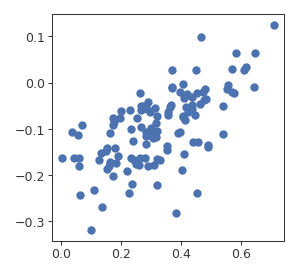

In [17]:
plt.figure(figsize=(2,2), dpi=150)
plt.plot(dTA_earlyB[0], dTA_peripheryB[0], '.')
(
    stats.ttest_1samp(dTA_earlyB[0], 0, alternative='greater'),
    stats.ttest_1samp(dTA_peripheryB[0], 0, alternative='less'),
    stats.ttest_rel(dTA_earlyB[0], dTA_peripheryB[0], alternative='greater'))

dXnotA joint < TA-only: t = -3.2, p = 0.000921
dTA_A joint < TA-only: t = -2.3, p = 0.0118


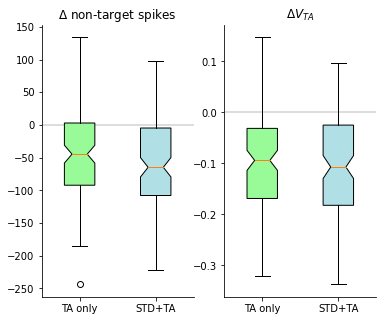

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(6,5))
for ax in axs:
    ax.axhline(0, color='lightgrey')
labels = 'TA only', 'STD+TA'
colors = 'palegreen', 'powderblue'
axs[0].set_title('$\\Delta$ non-target spikes')
b = axs[0].boxplot(
    [dXnotA[i].sum(1) for i in cfg.STDs],
    notch=True, widths=.4,
    labels=labels, patch_artist=True)
for patch, color in zip(b['boxes'], colors):
    patch.set_facecolor(color)
axs[1].set_title('$\\Delta V_{TA}$')
b = axs[1].boxplot(
    [np.median(dTA_A[i][:, :cfg.params['N_exc']], 1) for i in cfg.STDs],
    notch=True, widths=.4,
    labels=labels, patch_artist=True)
for patch, color in zip(b['boxes'], colors):
    patch.set_facecolor(color)
sns.despine()
test = stats.ttest_rel(np.sum(dXnotA[1], 1), np.sum(dXnotA[0], 1), alternative='less')
print(f'dXnotA joint < TA-only: t = {test.statistic:.2g}, p = {test.pvalue:.3g}')
test = stats.ttest_rel(np.median(dTA_A[1][:, :cfg.params['N_exc']], 1), np.median(dTA_A[0][:, :cfg.params['N_exc']], 1), alternative='less')
print(f'dTA_A joint < TA-only: t = {test.statistic:.2g}, p = {test.pvalue:.3g}')

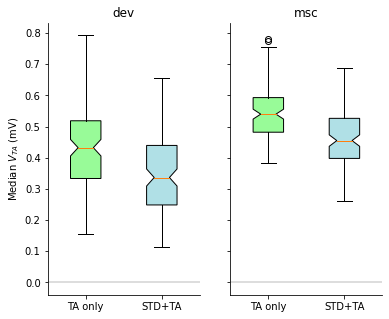

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(6,5), sharey=True)
for ax in axs:
    ax.axhline(0, color='lightgrey')
labels = 'TA only', 'STD+TA'
colors = 'palegreen', 'powderblue'
axs[0].set_ylabel('Median $V_{TA}$ (mV)')
for cond, ax in zip(('dev', 'msc'), axs):
    ax.set_title(cond)
    b = ax.boxplot(
        [np.asarray([np.median(ta['A'][cond][:cfg.params['N_exc']]) for ta in TAdata[STD]]) for STD in cfg.STDs],
        notch=True, widths=.4,
        labels=labels, patch_artist=True)
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)
sns.despine()

### Number of neurons with reduced response due to stim change is correlated with that due to adaptation
Correlation is positive for STD, negative for TA and TA+STD. With TA, a larger response to B means fewer stim change reductions, but more room for adaptation to take hold. Conversely, with STD only, large responses to B overwhelm STD, since even in large responses, individual spiking is sparse; while small responses are more strongly dominated by the direct response to the densely firing neurons near the stimulation site and therefore amenable to depression of repeated spikes.

WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 [py.warnings]


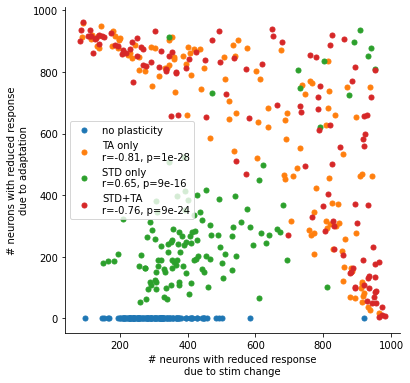

In [9]:
plt.figure(figsize=(6,6))
for STD in cfg.STDs:
    for TA in cfg.TAs:
        s, a = (stimchange[STD][TA]<0).sum(1), (adaptation[STD][TA]<0).sum(1)
        r, p = stats.pearsonr(s, a)
        lbl = f'{label(STD, TA)}\nr={r:.2f}, p={p:.1g}' if np.all(~np.isnan([r,p])) else label(STD, TA)
        plt.plot(s, a, 'o', ms=5, label=lbl)
plt.legend()
plt.xlabel('# neurons with reduced response\ndue to stim change')
plt.ylabel('# neurons with reduced response\ndue to adaptation')
sns.despine()

Considering only the overlap of the reduced-firing pool and the Amsc-responding pool lessens the TA-driven correlations.

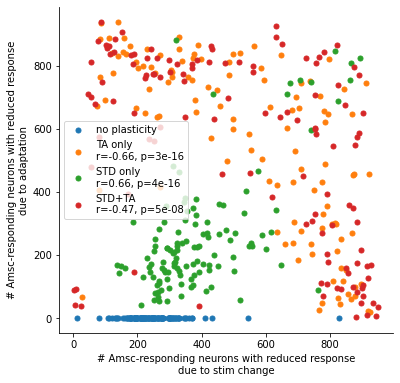

In [10]:
plt.figure(figsize=(6,6))
for STD in cfg.STDs:
    for TA in cfg.TAs:
        s, a = stimchange_freed[STD][TA].sum(1), adaptation_freed[STD][TA].sum(1)
        r, p = stats.pearsonr(s, a)
        lbl = f'{label(STD, TA)}\nr={r:.2f}, p={p:.1g}' if np.all(~np.isnan([r,p])) else label(STD, TA)
        plt.plot(s, a, 'o', ms=5, label=lbl)
plt.legend()
plt.xlabel('# Amsc-responding neurons with reduced response\ndue to stim change')
plt.ylabel('# Amsc-responding neurons with reduced response\ndue to adaptation')
sns.despine()

### No carry-over: No difference in number of neurons with reduced response between TA and TA+STD due to either effect alone

t = -0.9, p = 0.37


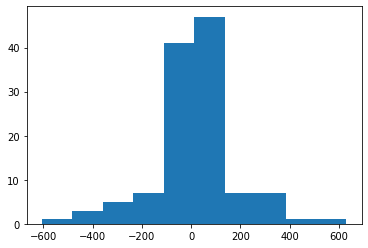

In [30]:
stimch = [(stimchange[STD][TA]<0).sum(1) for TA in cfg.TAs for STD in cfg.STDs]
plt.hist(stimch[3] - stimch[2])
# plt.boxplot(stimch, notch=True, labels=[label(STD, TA) for TA in cfg.TAs for STD in cfg.STDs])
test = stats.ttest_rel(stimch[2], stimch[3])
print(f't = {test.statistic:.2g}, p = {test.pvalue:.2g}')

t = -0.16, p = 0.88


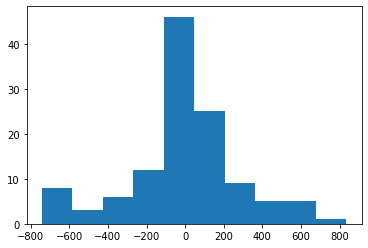

In [31]:
adapt = [(adaptation[STD][TA]<0).sum(1) for TA in cfg.TAs for STD in cfg.STDs]
plt.hist(adapt[3] - adapt[2])
# plt.boxplot(adapt, notch=True, labels=[label(STD, TA) for TA in cfg.TAs for STD in cfg.STDs])
test = stats.ttest_rel(adapt[2], adapt[3])
print(f't = {test.statistic:.2g}, p = {test.pvalue:.2g}')

### Total number of neurons with reduced response is larger in TA+STD than in TA

median: 10.5, t = -5.9, p = 1.8e-08


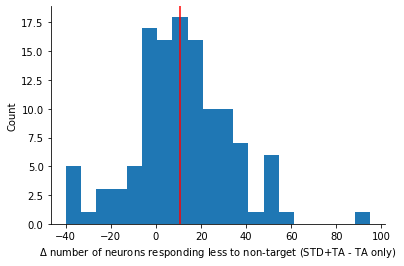

In [33]:
freed = [((stimchange[STD][TA]<0) | (adaptation[STD][TA]<0)).sum(1) for TA in cfg.TAs for STD in cfg.STDs]
plt.hist(freed[3] - freed[2], 20)
plt.axvline(np.median(freed[3]-freed[2]), color='r')
plt.xlabel('$\\Delta$ number of neurons responding less to non-target (STD+TA - TA only)')
plt.ylabel('Count')
sns.despine()
# plt.boxplot(freed, notch=True, labels=[label(STD, TA) for TA in cfg.TAs for STD in cfg.STDs])
test = stats.ttest_rel(freed[2], freed[3], alternative='less')
print(f'median: {np.median(freed[3]-freed[2]):.1f}, t = {test.statistic:.2g}, p = {test.pvalue:.2g}')

### Size of Bmsc response is correlated with its reduction in Bstd
The correlation is positive for TA and TA+STD, negative for STD-only.

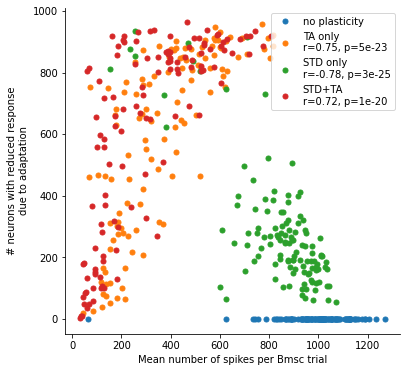

In [14]:
plt.figure(figsize=(6,6))
for STD in cfg.STDs:
    for TA in cfg.TAs:
        Bmsc = nB[STD][TA]['msc'].sum(1)
        a = (adaptation[STD][TA]<0).sum(1)
        r, p = stats.pearsonr(Bmsc, a)
        lbl = f'{label(STD, TA)}\nr={r:.2f}, p={p:.1g}' if np.all(~np.isnan([r,p])) else label(STD, TA)
        plt.plot(Bmsc, a, 'o', ms=5, label=lbl)
plt.legend()
plt.xlabel('Mean number of spikes per Bmsc trial')
plt.ylabel('# neurons with reduced response\ndue to adaptation')
sns.despine()

### No compound debt: Adding STD does not decrease small Bmsc responses more than large ones
nor does it affect the adaptation pool differentially.

({'r': 0.07229539264200835, 'p': 0.4326326785354067},
 Ttest_1sampResult(statistic=0.15703764266889864, pvalue=0.4377406555008281))

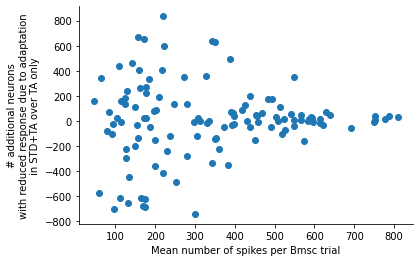

In [15]:
Bmsc = (nB[0][1]['msc'].sum(1) + nB[1][1]['msc'].sum(1))/2
delta_adapt = (adaptation[1][1]<0).sum(1) - (adaptation[0][1]<0).sum(1)
plt.scatter(Bmsc, delta_adapt)
plt.xlabel('Mean number of spikes per Bmsc trial')
plt.ylabel(f'# additional neurons\nwith reduced response due to adaptation\nin {label(1,1)} over {label(0,1)}')
sns.despine()
dict(zip('rp', stats.pearsonr(Bmsc, delta_adapt))), stats.ttest_1samp(delta_adapt, 0, alternative='greater')

({'r': 0.038429147375525954, 'p': 0.6768847274485377},
 Ttest_1sampResult(statistic=-12.729676137552577, pvalue=2.965575279055659e-24))

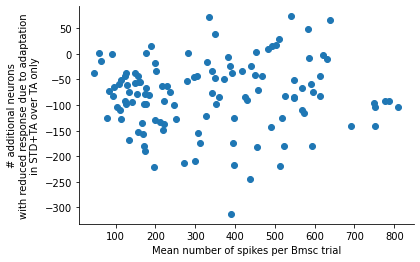

In [16]:
Bmsc = (nB[0][1]['msc'].sum(1) + nB[1][1]['msc'].sum(1))/2
delta_Bstd = nB[1][1]['std'].sum(1) - nB[0][1]['std'].sum(1)
plt.scatter(Bmsc, delta_Bstd)
plt.xlabel('Mean number of spikes per Bmsc trial')
plt.ylabel(f'# additional neurons\nwith reduced response due to adaptation\nin {label(1,1)} over {label(0,1)}')
sns.despine()
dict(zip('rp', stats.pearsonr(Bmsc, delta_Bstd))), stats.ttest_1samp(delta_Bstd, 0, alternative='less')

### Total number of freed-up neurons is only weakly correlated with DDI in TA conditions

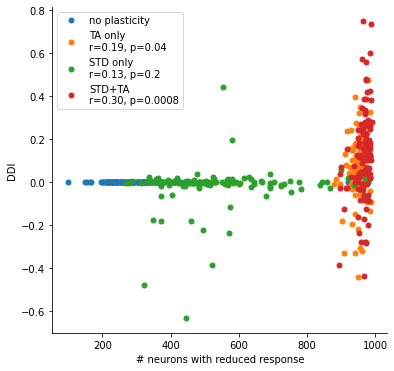

In [17]:
plt.figure(figsize=(6,6))
for STD in cfg.STDs:
    for TA in cfg.TAs:
        reduction = ((stimchange[STD][TA]<0) | (adaptation[STD][TA]<0)).sum(1)
        ddi = index(nA[STD][TA]['dev'].sum(1), nA[STD][TA]['msc'].sum(1))
        r, p = stats.pearsonr(reduction, ddi)
        lbl = f'{label(STD, TA)}\nr={r:.2f}, p={p:.1g}' if np.all(~np.isnan([r,p])) else label(STD, TA)
        plt.plot(reduction, ddi, 'o', ms=5, label=lbl)
plt.legend()
plt.xlabel('# neurons with reduced response')
plt.ylabel('DDI')
sns.despine()

The correlations are not significant when considering only the overlap.

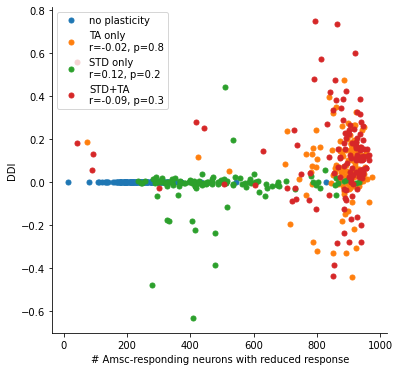

In [18]:
plt.figure(figsize=(6,6))
for STD in cfg.STDs:
    for TA in cfg.TAs:
        reduction = (stimchange_freed[STD][TA] | adaptation_freed[STD][TA]).sum(1)
        ddi = index(nA[STD][TA]['dev'].sum(1), nA[STD][TA]['msc'].sum(1))
        r, p = stats.pearsonr(reduction, ddi)
        lbl = f'{label(STD, TA)}\nr={r:.2f}, p={p:.1g}' if np.all(~np.isnan([r,p])) else label(STD, TA)
        plt.plot(reduction, ddi, 'o', ms=5, label=lbl)
plt.legend()
plt.xlabel('# Amsc-responding neurons with reduced response')
plt.ylabel('DDI')
sns.despine()

### STD-only DDI is correlated with rank-0 response size; TA DDI is (weakly) correlated with ranks 3-4 response size

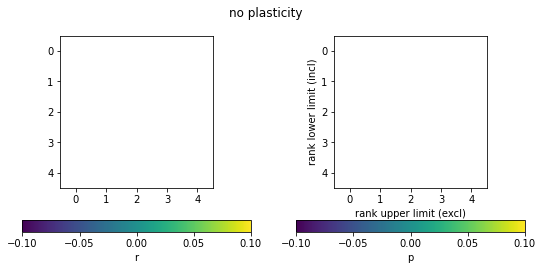

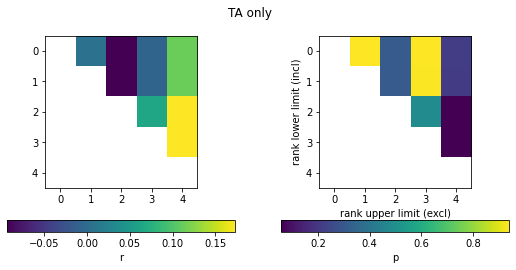

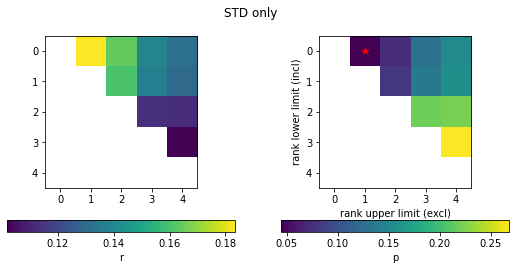

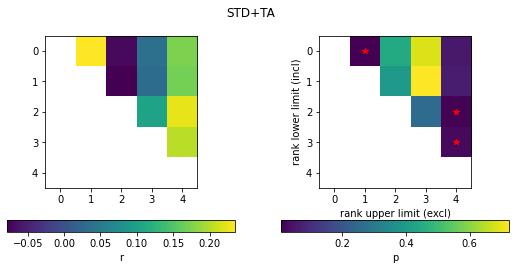

In [19]:
r, p = np.full((2, dA.max()+1, dA.max()+1), np.nan)
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for rank_hi in range(dA.max()+1):
            for rank_lo in range(rank_hi):
                reduction = (((stimchange[STD][TA]<0) | (adaptation[STD][TA]<0)) & (dA>=rank_lo) & (dA<rank_hi)).sum(1)
                ddi = index(nA[STD][TA]['dev'].sum(1), nA[STD][TA]['msc'].sum(1))
                r[rank_lo, rank_hi], p[rank_lo, rank_hi] = stats.pearsonr(reduction, ddi)
        fig, axs = plt.subplots(1, 2, figsize=(9,4))
        fig.suptitle(label(STD, TA))
        m = axs[0].imshow(r)
        plt.colorbar(m, ax=axs[0], orientation='horizontal', label='r')
        m = axs[1].imshow(p)
        plt.colorbar(m, ax=axs[1], orientation='horizontal', label='p')
        plt.xlabel('rank upper limit (excl)')
        plt.ylabel('rank lower limit (incl)')
        for y, px in enumerate(p):
            for x, p_ in enumerate(px):
                if p_ < .05:
                    axs[1].plot(x, y, 'r*')

### TBC: Small responses = higher spike count in participating neurons
This would confirm the hypothesis that small responses are more amenable to STD reductions

### Some carry-over: STD increases the reduction of Bstd vs Bmsc in terms of spikes/neuron
There is a slight increase in the reduction of around 0.4-0.5 spikes per neuron, but there is no increase in the number of neurons reducing their response.

median: 0.42, t = 19, p = 3.4e-37


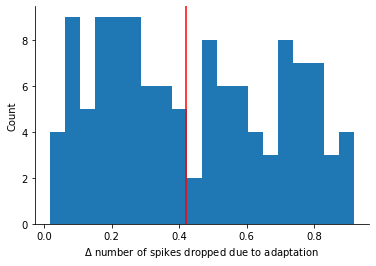

In [36]:
adaptation_increase = ((adaptation[1][1] - adaptation[0][1])>0).mean(1)
plt.hist(adaptation_increase, 20)
plt.axvline(np.median(adaptation_increase), color='r')
plt.xlabel('$\\Delta$ number of spikes dropped due to adaptation')
plt.ylabel('Count')
sns.despine()
test = stats.ttest_1samp(adaptation_increase, 0, alternative='greater')
print(f'median: {np.median(adaptation_increase):.2f}, t = {test.statistic:.2g}, p = {test.pvalue:.2g}')

Ttest_1sampResult(statistic=0.15703764266889864, pvalue=0.4377406555008281)

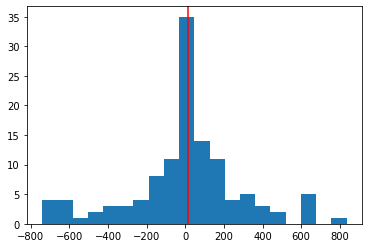

In [21]:
adaptation_increase = (adaptation[1][1]<0).sum(1) - (adaptation[0][1]<0).sum(1)
plt.hist(adaptation_increase, 20)
plt.axvline(np.median(adaptation_increase), color='r')
stats.ttest_1samp(adaptation_increase, 0, alternative='greater')

median: 0.53, t = 22, p = 2.7e-43


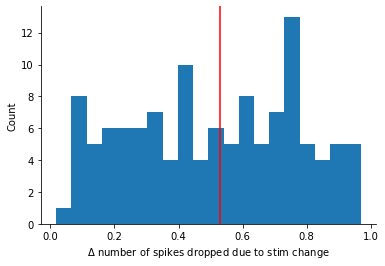

In [37]:
stimchange_increase = ((stimchange[1][1] - stimchange[0][1])>0).mean(1)
plt.hist(stimchange_increase, 20)
plt.axvline(np.median(stimchange_increase), color='r')
plt.xlabel('$\\Delta$ number of spikes dropped due to stim change')
plt.ylabel('Count')
sns.despine()
test = stats.ttest_1samp(stimchange_increase, 0, alternative='greater')
print(f'median: {np.median(stimchange_increase):.2f}, t = {test.statistic:.2g}, p = {test.pvalue:.2g}')

Ttest_1sampResult(statistic=0.8988886137855582, pvalue=0.1852636216547452)

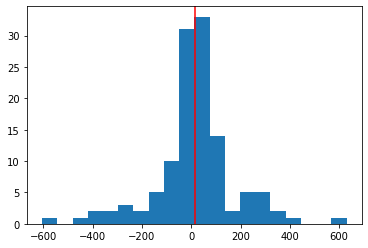

In [23]:
stimchange_increase = (stimchange[1][1]<0).sum(1) - (stimchange[0][1]<0).sum(1)
plt.hist(stimchange_increase, 20)
plt.axvline(np.median(stimchange_increase), color='r')
stats.ttest_1samp(stimchange_increase, 0, alternative='greater')

### Reduced response in Bstd is correlated with lower $V_{TA}$

In [24]:
voltages = dd.io.load('Fig5o-stats.h5', '/voltages')

{'r': 0.9081510978724728, 'p': 1.921640759159551e-46}

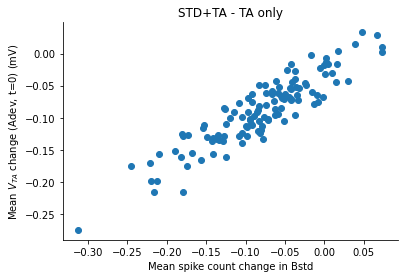

In [25]:
b = (nB[1][1]['std'] - nB[0][1]['std']).mean(1)
v = (voltages[1]['dev']['Threshold'][:, :, 0] - voltages[0]['dev']['Threshold'][:, :, 0]).mean(1)*volt/mV
plt.scatter(b, v)
plt.title(f'{label(1,1)} - {label(0,1)}')
plt.xlabel('Mean spike count change in Bstd')
plt.ylabel('Mean $V_{TA}$ change (Adev, t=0) (mV)')
sns.despine()
dict(zip('rp', stats.pearsonr(b, v)))

### Lower $V_{TA}$ is correlated with higher Adev

{'r': -0.42826574476927953, 'p': 1.0634075671661359e-06}

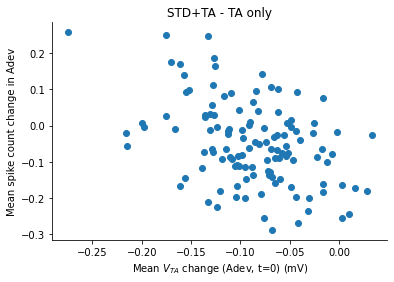

In [26]:
a = (nA[1][1]['dev'] - nA[0][1]['dev']).mean(1)
v = (voltages[1]['dev']['Threshold'][:, :, 0] - voltages[0]['dev']['Threshold'][:, :, 0]).mean(1)*volt/mV
plt.scatter(v, a)
plt.title(f'{label(1,1)} - {label(0,1)}')
plt.xlabel('Mean $V_{TA}$ change (Adev, t=0) (mV)')
plt.ylabel('Mean spike count change in Adev')
sns.despine()
dict(zip('rp', stats.pearsonr(v, a)))

### Lower $V_{TA}$ is correlated with higher DDI

{'r': -0.4613122600548931, 'p': 1.1410678904427202e-07}

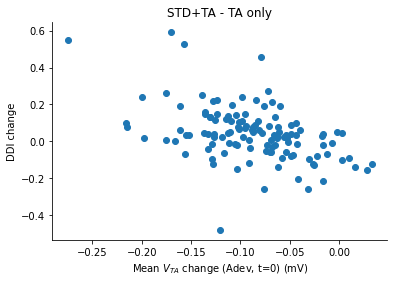

In [27]:
ddi = index(nA[1][1]['dev'].sum(1), nA[1][1]['msc'].sum(1)) - index(nA[0][1]['dev'].sum(1), nA[0][1]['msc'].sum(1))
v = (voltages[1]['dev']['Threshold'][:, :, 0] - voltages[0]['dev']['Threshold'][:, :, 0]).mean(1)*volt/mV
plt.scatter(v, ddi)
plt.title(f'{label(1,1)} - {label(0,1)}')
plt.xlabel('Mean $V_{TA}$ change (Adev, t=0) (mV)')
plt.ylabel('DDI change')
sns.despine()
dict(zip('rp', stats.pearsonr(v, ddi)))

Also: Higher Adev is correlated with higher DDI

{'r': 0.3406156082882706, 'p': 0.00014084352222851063}

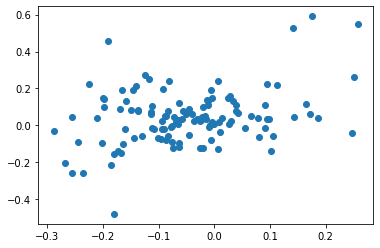

In [28]:
plt.scatter(a, ddi)
dict(zip('rp', stats.pearsonr(a, ddi)))

Also: Lower Bstd is correlated with higher DDI

{'r': -0.468546362785362, 'p': 6.778188278594276e-08}

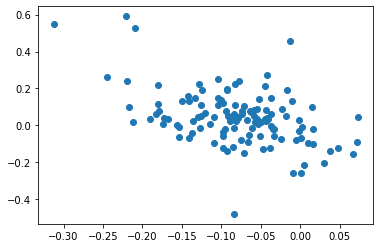

In [29]:
plt.scatter(b, ddi)
dict(zip('rp', stats.pearsonr(b, ddi)))